# Modelos BERT

## 1. Introducción a BERT

BERT es un acrónimo de *Bidirectional Encoder Representations from Transformers* y representa un tipo de red neuronal denominada ***transformer*** que es capaz de realizar varios **procesamientos en paralelo** sobre un mismo texto puesto que no sigue un orden específico de lectura ya que puede analizar términos en ambas direcciones. Esta arquitectura ha sido desarrollada por Google y se encuentra compuesta por **múltiples *encoders*** capaces de **extraer características y codificar documentos** proporcionados como entrada. Este modelo dispone de **mecanismos de atención y capas *feed-forward*** con las que aprende las **relaciones contextuales** existentes entre términos y subtérminos dentro de un conjunto de textos.


### 1.1. Condiciones de uso

Es un requisito indispensable la aplicación de un **formateo específico** para proporcionarle al modelo un conjunto de **documentos como entrada**. Para ello se debe diseñar un procedimiento que contenga los siguientes pasos.

   1. En primer lugar se debe ***tokenizar*** todos los documentos, es decir, separar cada uno de ellos en *tokens* o palabras individuales.

   2. A continuación se deben incluir **dos tokens adicionales** para marcar **el inicio y el final** de una secuencia de texto. Por lo tanto el primer token de una frase debe ser *[CLS]* mientras que el último token que cierra la secuencia de términos debe ser *[SEP]*.

   3. Finalmente cada secuencia de términos debe tener una **longitud fija de 512** tokens. Si es inferior se deberá alcanzar dicha cifra completando los huecos vacíos con tantos tokens *[PAD]* como sean necearios. Si es superior entonces se deberá truncar la secuencia y dividirla en varias siempre respetando el tamaño prefijado.

### 1.2. Casos de uso

* Detección y clasificación de documentos.
* Mecanismos de preguntas y respuestas.
* Análisis de sentimientos.
* Generación de textos en lenguaje natural para múltiples idiomas.
* Detección y extracción de patrones en documentos.

## 2. Estructura del notebook

1. Introducción a BERT
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Experimentos y modelos
6. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
%%capture
# pandas: to read the datasets
import pandas as pd

# numpy: to work with Numpy ndarrays
import numpy as np

# tensorflow / transformers: to work with pre-trained BERT models
import tensorflow as tf
from transformers import *

# sklearn: to calculate validation metrics and a confusion matrix
from sklearn import metrics

# matplotlib: to plot charts
import matplotlib.pyplot as plt
 
import sys
sys.path.append('../scripts')

# data: to analyze test predictions
from data import analyze_predicted_probs, map_texts_to_emotions

2023-03-15 08:22:57.498123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 08:22:57.974810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 08:22:57.974876: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 08:22:59.155581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 4. Lectura y carga de datos procesados

En esta sección se pretende leer y cargar los datos de entrenamiento y test ya procesados a los que se les ha aplicado las siguientes técnicas de tratamiento de documentos:

  - Elimina URLs.
  - Elimina usuarios mencionados.
  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Convierte todos los caracteres en minúsculas.
  - **No se aplica lematización** puesto que el rendimiento del modelo apenas mejora aunque el tiempo invertido se multiplica exponencialmente.
  - **No se intenta detectar y corregir palabras erróneamente escritas** puesto que tampoco mejora el rendimiento del modelo pero la inversión de recursos es desorbitada. Según he podido comprobar apenas se detecta un 9,43% de términos con faltas de ortogragía y solo un 7,61% son corregidos, por lo que esta técnica no parece que vaya a ser de utilidad. </p>

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.865 muestras**.
* Conjunto de validación: **4.296 muestras**.

In [2]:
# Read already processed EXIST datasets
train_df = pd.read_csv('../data/proc_EXIST2021_train.csv')
test_df = pd.read_csv('../data/proc_EXIST2021_test.csv')

# Show the dimensions of the datasets
print('Train dataset dimensions:', train_df.shape)
print('Test dataset dimensions:', test_df.shape)

Train dataset dimensions: (6865, 6)
Test dataset dimensions: (4296, 6)


## 5. Experimentos y modelos

En esta sección se pretende ejemplificar la mejor configuración obtenida en relación a la combinación de distintas técnicas de procesamiento de textos, codificación de documentos y arquitecturas BERT, como modelos de Aprendizaje Automático avanzados. A diferencia de los clasificadores entrenados con Regresión Logística, los experimentos efectuados con BERT **no son determinísticos**. Como consecuencia, para evaluar el impacto de las modificaciones realizadas sobre los datasets y las arquitecturas se ejecutan **30 iteraciones de cada experimento** para luego calcular la **media de accuracy y AUC**, como métricas de evaluación seleccionadas para medir la calidad de un clasificador. Para más detalles se puede consultar [este notebook](https://github.com/lidiasm/DATCOM-TFM/blob/main/notebooks/run_bert_experiments.ipynb) donde se encuentra codificado el procedimiento descrito.

Tal y como se explica en ambas competiciones, se realiza una **distinción entre textos en inglés y español** puesto que parece ser que estos últimos se caracterizan por una mejor representación y por ende, los **clasificadores entrenados únicamente sobre documentos españoles demuestran una mayor capacidad de predicción**.

Previo al comienzo de la experimentación se definen las siguientes funciones con las que tokenizar los documentos de entrenamiento y test para su uso con arquitecturas BERT, así como para la validación de los clasificadores sobre sendos datasets. 

In [3]:
def tokenize_texts(texts: list, labels: list, bert_tokenizer: BertTokenizer):
    '''
    A function that tokenizes the provided list of texts using a pre-trained
    Bert tokenizer to encode the documents to get them ready for BERT models.

    Parameters
    ----------
    texts : list
        A list of strings with the documents to encode as BERT tokens.
    labels : int
        A list of integers with the class labels to encode as a Numpy array.
    bert_tokenizer : BertTokenizer
        A pre-trained BERT tokenizer to use to encode the documents for BERT models.
    
    Returns
    -------
    A dictionary with the tokenized texts, the created attention
    masks for the BERT models as well as the transformed class labels
    within a Numpy array.
    '''
    tokenized_texts = []
    attention_masks = []

    # Tokenize the provided texts using BERT tokenizer
    for doc in texts:
        bert_inp = bert_tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            max_length=64,
            pad_to_max_length=True,
            return_attention_mask=True)

        # Get the tokenized texts along with the attention masks
        tokenized_texts.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    return {
        'tokenized_texts': np.asarray(tokenized_texts),
        'attention_masks': np.asarray(attention_masks),
        'labels': np.asarray(labels),
    }

In [4]:
def validate_bert_model(
    train_labels: list, train_pred_labels: list,
    test_labels: list, test_pred_labels: list):
    '''
    Computes the validation metrics of accuracy and AUC based
    on the provided train and test labels, as well as the train
    and test predicted labels by a BERT model.

    Parameters
    ----------
    train_labels : list
        A list of integers with the real train class labels.
    train_pred_labels : list
        A list of integers with the predicted train class labels.
    test_labels : list
        A list of integers with the real test class labels.
    test_pred_labels : list
        A list of integers with the predicted test class labels.
    '''
    # Calculate the accuracy and AUC values over the train dataset
    print(f'Train accuracy: {(metrics.accuracy_score(train_labels, train_pred_labels))}')
    print(f'Train AUC: {(metrics.roc_auc_score(train_labels, train_pred_labels))}')
    
    # Calculate the accuracy and AUC values over the test dataset
    print(f'Test accuracy: {(metrics.accuracy_score(test_labels, test_pred_labels))}')
    print(f'Test AUC: {(metrics.roc_auc_score(test_labels, test_pred_labels))}')

    # Plot the confusion matrix 
    metrics.ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusion_matrix(
            np.array(test_labels), 
            np.array(test_pred_labels)), 
        display_labels=['Non-sexist', 'Sexist']) \
    .plot()

### 5.1. Modelo específico para inglés

* **Data Augmentation**. Ha sido con arquitecturas BERT con las que se ha conseguido una diferencia sustancial en las métricas de validación al generar muestras sintéticas en el conjunto de entrenamiento para aumentar su volumen. En particular, para este clasificador inglés se ha utilizado ***Easy Data Augmentation*** **basado en el reemplazamiento de dos palabras, seleccionadas aleatoriamente, por sus sinónimos aplicado dos veces por documento** generando así el doble de muestras de entrenamiento. Por lo tanto el conjunto final, añadiendo los textos originales, sería tres veces más voluminoso.

* **Tokenización de textos** empleando el tokenizador pre-entrenado denominado ***bert-base-uncased*** que se encuentra disponible en Hugging Face. Únicamente se puede utilizar sobre documentos en inglés.

* **Arquitectura e hiperparámetros**.
    * **Modelo pre-entrenado** sobre un corpus de textos en inglés.
    * **110 millones de parámetros**. 
    * Doble objetivo de entrenamiento
        * Masked Language Modeling (MLM): predice palabras que aleatoriamente se reemplazan por máscaras.
        * Next Sentence Prediction (NSP): predice si un par de frases son secuenciales o no.
    * **Tamaño del lote: 8**.
    * Tamaño máximo de un token: 64. </p>

* **Entrenamiento y validación**.
  * Número máximo de **iteraciones**: 100.
  * **Early Stopping** tras 15 iteraciones sin una mejora mayor que 0.01 en el valor de la métrica *accuracy* en validación y recuperando los pesos del mejor modelo encontrado. 
  * Porcentaje de **validación**: 20%.
  * Función de pérdida: *sparse_categorical_crossentropy*.
  * Optimizador: Adam con una tasa de aprendizaje de 2e-5.
  * **Métricas de validación**: *accuracy*.

En los siguientes resultados se puede apreciar una fortísima diferencia de más del 20% en la tasa de aciertos sobre el conjunto de entrenamiento en comparación con la relativa a test, por lo que parece que el **modelo está sobreaprendiendo**. Si bien la tasa de aciertos sobre test apenas alcanza el 73%, se debe considerar que la máxima expuesta **en sendas competiciones no aumentaba del 79% para textos en inglés y utilizando ensembles**, no clasificadores individuales.

No obstante, observando la matriz de confusión se aprecia una considerable **reducción de las tasas de falsos positivos y negativos** en comparación con los clasificadores entrenados con Regresión Logística y LSTM, por lo tanto parece que una arquitectura BERT puede resultar más ventajosa de utilizar para solventar este problema de clasificación de sexismo.

/home/lidia/DATCOM-TFM/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


69/69 [==============================] - 160s 2s/step
Train accuracy: 0.9958738579428235
Train AUC: 0.9957830045787704
Test accuracy: 0.735415709692237
Test AUC: 0.7336094158674803


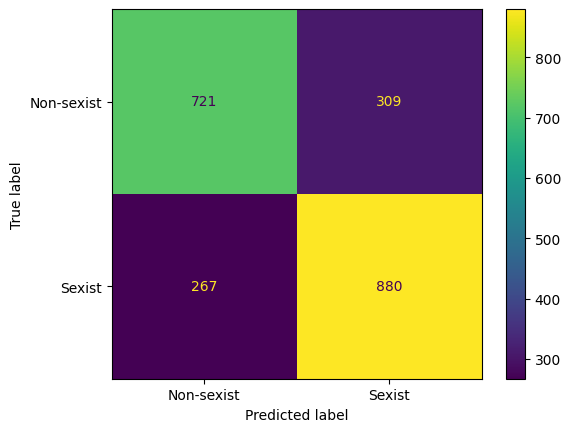

In [33]:
# Load a pre-trained BertTokenizer for English texts
BERT_TOKENIZER_OBJ = BertTokenizer.from_pretrained('bert-base-uncased')

# Filter train and test texts by language
en_train_df = train_df[train_df['language'] == 'en']
en_test_df = test_df[test_df['language'] == 'en']

# Tokenize the train documents
en_bert_encoded_train_data = tokenize_texts(
    texts=list(en_train_df['clean_text'].values),
    labels=list(en_train_df['task1'].values),
    bert_tokenizer=BERT_TOKENIZER_OBJ)

# Tokenize the test documents
en_bert_encoded_test_data = tokenize_texts(
    texts=list(en_test_df['clean_text'].values),
    labels=list(en_test_df['task1'].values),
    bert_tokenizer=BERT_TOKENIZER_OBJ)

# Load a trained BERT classifier
en_bert_model = TFBertForSequenceClassification.from_pretrained('../models/en_bert_models/en_bert_model_synN2X2_2e5LR_8BS')

# Create the predictions over the train dataset
en_train_preds = en_bert_model.predict(
[
    en_bert_encoded_train_data['tokenized_texts'], 
    en_bert_encoded_train_data['attention_masks']
])
en_train_pred_labels = np.argmax(en_train_preds.logits, axis=1)

# Create the predictions over the test dataset
en_test_preds = en_bert_model.predict(
[
    en_bert_encoded_test_data['tokenized_texts'], 
    en_bert_encoded_test_data['attention_masks']
])
en_test_pred_labels = np.argmax(en_test_preds.logits, axis=1)

# Evaluate the model over train and test datasets
validate_bert_model(
    train_labels=en_bert_encoded_train_data['labels'],
    train_pred_labels=en_train_pred_labels,
    test_labels=en_bert_encoded_test_data['labels'],
    test_pred_labels=en_test_pred_labels
)

#### 5.1.1. Análisis de resultados

Como en los otros notebooks se replica el mismo procedimiento con el objetivo de intentar comprender las razones que llevan al modelo a clasificar erróneamente ciertas muestras. En este primer análisis se muestran los intervalos de confianza en los que se distribuyen los falsos positivos y negativos. Tal y como se aprecia, en ambos casos **la mayoría se encuentran en intervalos elevados de confianza** por lo que parece que el clasificador está bastante seguro de las decisiones que ha tomado.

In [37]:
# Predict over the test dataset
en_test_probs = [max(value) for value in np.asarray(tf.nn.sigmoid(en_test_preds.logits))]

# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_pred_labels
en_test_df['task1_pred_probs'] = en_test_probs

print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 59 samples
Confidence Interval High (0.6, 0.8): 68 samples
Confidence Interval Very high (0.8, 1.0): 140 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 72 samples
Confidence Interval High (0.6, 0.8): 65 samples
Confidence Interval Very high (0.8, 1.0): 172 samples


/tmp/ipykernel_10921/1074265913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_test_df['task1_pred_classes'] = en_test_pred_labels
/tmp/ipykernel_10921/1074265913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_test_df['task1_pred_probs'] = en_test_probs


A continuación se cruzan los falsos negativos, es decir, documentos sexistas erróneamente clasificados con las categorías sexistas a las que pertenecen. De nuevo se aprecia la misma tendencia vista en otros modelos puesto que en los p**rimeros puestos se observan las clases más complicadas de detectar** por modelos automáticos debido a su contenido que resulta confuso de identificar ya que no contiene suficiente terminología negativa y violenta.

In [38]:
false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False)

,id
task2,
ideological-inequality,80
stereotyping-dominance,60
sexual-violence,49
misogyny-non-sexual-violence,46
objectification,32


Finalmente si se realiza un estudio desde el punto de vista de las emociones detectadas según el contenido de los documentos erróneamente clasificados, se observa de nuevo que las **dos emociones mayoritarias son *anger* y *joy***, cuyos textos se caracterizan por disponer de un **alto porcentaje de ironía** y con terminología y expresiones positivas aunque con **significados nada éticos y completamente sexistas**, respectivamente.

In [39]:
print('FALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Emotion: fear - No. of texts: 25
Emotion: surprise - No. of texts: 6
Emotion: love - No. of texts: 8
Emotion: sadness - No. of texts: 32
Emotion: anger - No. of texts: 117
Emotion: joy - No. of texts: 79

FALSE POSITIVES
Emotion: fear - No. of texts: 41
Emotion: surprise - No. of texts: 6
Emotion: love - No. of texts: 3
Emotion: sadness - No. of texts: 42
Emotion: anger - No. of texts: 132
Emotion: joy - No. of texts: 85


### 5.2. Modelo específico para español

* **Data Augmentation**. Al igual que el modelo anterior, para arquitecturas BERT se ha observado un aumento en las métricas de accuracy y AUC de más de 7% al generar muestras sintéticas en el conjunto de entrenamiento. En este caso la técnica más beneficiosa ha sido aplicar ***Easy Data Augmentation*** **basado en el reemplazamiento de una palabra, seleccionada aleatoriamente, por su sinónimo aplicado tres veces por documento** generando así el triple de muestras de entrenamiento. Por lo tanto el conjunto final, añadiendo los textos originales, sería cuatro veces más voluminoso.

* **Tokenización de textos** empleando el tokenizador pre-entrenado denominado ***dccuchile/bert-base-spanish-wwm-uncased*** que se encuentra disponible en Hugging Face. Únicamente se puede utilizar sobre documentos en español.

* **Arquitectura e hiperparámetros**. El modelo y su configuración es idéntica a la anterior aunque entrenado sobre un volumen considerable de textos en español.

* **Entrenamiento y validación**. La configuración es idéntica a la anterior con la salvedad de establecer en este caso una tasa de aprendizaje algo inferior a 1e-5.

A continuación se muestran las métricas de validación para este clasificador y al igual que en el caso anterior existe una desmesurada diferencia entre las basadas en entrenamiento y test, por lo que el modelo parece que **sobreajusta** aunque dispone de una **mayor capacidad de predicción** con una tasa de aciertos de más del 77%, siendo la **más alta alcanzada en sendas competiciones del 80% en textos españoles con ensembles**, no clasificadores individuales. 

En la matriz de confusión se refleja la mejoría obtenida con una **reducción tanto del número de falsos positivos y negativos, aunque el valor de estos últimos sigue estando muy elevado**.

Downloading: 100%|██████████| 248k/248k [00:01<00:00, 240kB/s]  
Downloading: 100%|██████████| 650/650 [00:00<00:00, 157kB/s]
/home/lidia/DATCOM-TFM/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2023-03-15 08:24:28.602834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 08:24:28.603063: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] f

67/67 [==============================] - 142s 2s/step
Train accuracy: 0.9979838709677419
Train AUC: 0.9979778747902195
Test accuracy: 0.7715903728173666
Test AUC: 0.7732802406298337


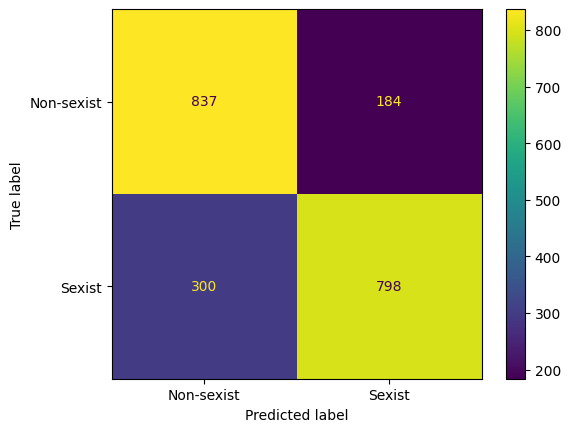

In [5]:
# Load a pre-trained BertTokenizer for Spanish texts
BERT_TOKENIZER_OBJ = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Filter train and test texts by language
es_train_df = train_df[train_df['language'] == 'es']
es_test_df = test_df[test_df['language'] == 'es']

# Tokenize the train documents
es_bert_encoded_train_data = tokenize_texts(
    texts=list(es_train_df['clean_text'].values),
    labels=list(es_train_df['task1'].values),
    bert_tokenizer=BERT_TOKENIZER_OBJ)

# Tokenize the test documents
es_bert_encoded_test_data = tokenize_texts(
    texts=list(es_test_df['clean_text'].values),
    labels=list(es_test_df['task1'].values),
    bert_tokenizer=BERT_TOKENIZER_OBJ)

# Load a trained BERT classifier
es_bert_model = TFBertForSequenceClassification.from_pretrained('../models/es_bert_models/es_bert_model_synN1X3_1e5LR_8BS')

# Create the predictions over the train dataset
es_train_preds = es_bert_model.predict(
[
    es_bert_encoded_train_data['tokenized_texts'], 
    es_bert_encoded_train_data['attention_masks']
])
es_train_pred_labels = np.argmax(es_train_preds.logits, axis=1)

# Create the predictions over the test dataset
es_test_preds = es_bert_model.predict(
[
    es_bert_encoded_test_data['tokenized_texts'], 
    es_bert_encoded_test_data['attention_masks']
])
es_test_pred_labels = np.argmax(es_test_preds.logits, axis=1)

# Evaluate the model over train and test datasets
validate_bert_model(
    train_labels=es_bert_encoded_train_data['labels'],
    train_pred_labels=es_train_pred_labels,
    test_labels=es_bert_encoded_test_data['labels'],
    test_pred_labels=es_test_pred_labels
)

#### 5.2.1. Análisis de resultados

Se replican los estudios realizados anteriormente para el modelo especializado en textos en español.

Tal y como se observa en los siguientes resultados, la tendencia es idéntica a la visualizada previamente puesto que la **mayoría de falsos positivos y negativos** se caracterizan por encontrarse en los **intervalos de confianza más altos**, por lo tanto parece que el clasificador tenía bastante certeza al cometer estos errores, lo que significa que no es un buen comportamiento.

In [6]:
# Predict over the test dataset
es_test_probs = [max(value) for value in np.asarray(tf.nn.sigmoid(es_test_preds.logits))]

# Insert the predicted classes and probabilities into the test dataset
es_test_df['task1_pred_classes'] = es_test_pred_labels
es_test_df['task1_pred_probs'] = es_test_probs

print('FALSE NEGATIVES')
false_negatives_df = es_test_df[(es_test_df['task1'] == 1) & (es_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = es_test_df[(es_test_df['task1'] == 0) & (es_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 28 samples
Confidence Interval High (0.6, 0.8): 65 samples
Confidence Interval Very high (0.8, 1.0): 207 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 17 samples
Confidence Interval High (0.6, 0.8): 50 samples
Confidence Interval Very high (0.8, 1.0): 117 samples


/tmp/ipykernel_4914/4049925990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_test_df['task1_pred_classes'] = es_test_pred_labels
/tmp/ipykernel_4914/4049925990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_test_df['task1_pred_probs'] = es_test_probs


Cruzando los falsos negativos, es decir, los textos sexistas no identificados con sus correspondientes categorías sexistas disponibles en el dataset de test, como se ha visualizado en el modelo LSTM de español **los textos erróneamente clasificados en este idioma se caracterizan por tener otra distribución**. En primer lugar se encuentra una categoría sexista que, tras una inspección visual, parece caracterizarse por documentos que albergan **protestas en contra de la violencia sexual** que no parecen ser textos sexistas puesto que son reivindicaciones, **faltas de ortografía y hashtags** que dificultan la codificación a embeddings, así como textos con **terminología positiva** aunque una fuerte connotación sexista. El resto de clases sexistas comparten estas dos últimas características además de **tratar de otros tópicos** como el racismo, la religión y la política.

In [7]:
false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False)

,id
task2,
sexual-violence,72
misogyny-non-sexual-violence,69
ideological-inequality,61
stereotyping-dominance,54
objectification,44


Finalmente mezclando los falsos positivos y negativos con las emociones detectadas durante el análisis exploratorio de datos, podemos visualizar que de nuevo **las dos emociones más populares son *joy* y *anger***. Las características de estos documentos se encuentran de acuerdo a las mencionadas anteriormente acerca de **terminología y expresiones positivas aunque con significados profundamente sexistas, además de textos con una elevada ironía** que de momento no puede ser detectada correctamente por modelos automáticos.

In [15]:
print('FALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Emotion: fear - No. of texts: 84
Emotion: joy - No. of texts: 117
Emotion: anger - No. of texts: 97
Emotion: sadness - No. of texts: 2

FALSE POSITIVES
Emotion: fear - No. of texts: 61
Emotion: anger - No. of texts: 41
Emotion: sadness - No. of texts: 3
Emotion: joy - No. of texts: 79
